In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as mp
import pandas as pd
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import markdown
import sys
sys.path.append('/Users/vs522/Dropbox/Python')
from astropy.table import Table
from astropy import units as u
import seaborn as sns
import os
import glob
import linecache
import re
from IPython.display import Image
import itertools
import reddening_laws as red
from astropy.stats import sigma_clip
import scipy.optimize as op
from astroquery.irsa_dust import IrsaDust
from astroquery.simbad import Simbad
from astropy import units as u
from astropy.coordinates import SkyCoord





bigfontsize=20
labelfontsize=16
tickfontsize=16
sns.set_context('talk')
mp.rcParams.update({'font.size': bigfontsize,
                     'axes.labelsize':labelfontsize,
                     'xtick.labelsize':tickfontsize,
                     'ytick.labelsize':tickfontsize,
                     'legend.fontsize':tickfontsize,
                     })

sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.0})

sns.set_palette("Set2")
colours = sns.color_palette()

/Users/vs522/anaconda3/envs/astroconda/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# RR Lyrae PLZ relation for use in SMHASH papers prior to Gaia DR2

* Working on RR Lyrae PLZ relation for use in SMHASH papers prior to Gaia DR2
* Current Gaia DR1 results are not good enough to derive an RRL PLZ relation that is *better than* that acheiveable from globular clusters and HST parallaxes.
* Need to wait for Gaia DR2 for full parallax solutions and consistent metallicities.
* Until then, using the following data:

1) M4 slope using updated photometry from Neeley -- ** important - need to know which reference to use here - is Neeley PhD thesis correct, or is there a paper in prep we can refer to? **

2) Metallcicities compiled by Beaton/Monson (Monson/Beaton/Scowcroft 2017 paper?) for Galactic Cepheids

3) Spitzer photometry from Scowcroft (which will be published in full in this paper).

### Neeley et al. PL relations from updated Spitzer photometry: [Link to google doc](https://docs.google.com/document/d/1u3MIKCe7GI8dsjDiEmUxmcDWLuy0oaILutW_vm2yZaE/edit)

* RRab only
$$ M_{[3.6]} = -2.342 \pm 0.140 \log P -1.155 \pm 0.089, \sigma = 0.130 $$

$$ M_{[4.5]}= -2.358 \pm 0.165 \log P -1.170 \pm 0.089, \sigma = 0.127 $$ 

* RRab + RRc (fundamentalized)
$$ M_{[3.6]} = -2.304 \pm 0.105 \log P -1.112 \pm 0.079, \sigma = 0.128 $$
$$ M_{[4.5]}= -2.340 \pm 0.104 \log P -1.139 \pm 0.079, \sigma = 0.125 $$

* Usage notes: 
  * When using a sample of *only* RRab stars, use the RRab only PL relations
  * When using a sample of RRab and RRc stars use the RRab + RRc (fundamentalized)
  * RRc stars are not yet well characterized enough (i.e. we don't have enough RRc stars) to look at RRc only PL relations.



### Grabbing RR Lyrae data from Monson et al. (2017) table 1 

In [2]:
## function to grab extinctio from IRSA dust service, add it to the data frame
def grab_extinction(row):
    star_name = row.Name
    print(star_name)
    result_table = Simbad.query_object(star_name)
    result_df = result_table.to_pandas()
    ra = result_df.RA.values[0]
    dec = result_df.DEC.values[0]
    print((ra, dec))
    table = IrsaDust.get_extinction_table(SkyCoord(ra, dec, frame='icrs', unit=(u.hour, u.deg)))
    irac_1_sandf = table[19][3]
    irac_2_sandf = table[20][3]
    rrl_df.ix[rrl_df.Name==star_name, 'A_3p6'] = float(irac_1_sandf)
    rrl_df.ix[rrl_df.Name==star_name, 'A_4p5'] = float(irac_2_sandf)
    print((star_name, irac_1_sandf, irac_2_sandf))
    return(0)
 

# DO NOT RUN CELL BELOW UNLESS REREADING DATA FROM SCRATCH

# HST parallax subset

* Benedict HST parallax subset (using values published in Neeley et al (2015) as these are corrected for typos's in Benedict:
  * RZ Cep: E(B-V) = 0.252, $\varpi = 2.54 \pm 0.19$
  * XZ Cyg: E(B-V) = 0.100  $\varpi = 1.67 \pm 0.17$
  * UV Oct: E(B-V) = 0.090  $\varpi = 1.71 \pm 0.10$
  * RR Lyr: E(B-V) = 0.042  $\varpi = 3.77 \pm 0.13$
  * SU Dra: E(B-V) = 0.010  $\varpi = 1.42 \pm 0.16$
* Not using the LKH correction (see arguments in various Monson papers/emails etc as to why it's not appropriate for this sample.

# How to get the PLZ from the big sample?

## Test one:

* Have calibrated PL relation using the HST sample and M4 slopes.
* Have apparent mags, [Fe/H] and can get extinctions for all of the sample from IRSA.


1. Grab extinctions for everything and get extinction corrected apparent mags
2. Derive PLZ using the 4 star RRab-only HST sample.
3. Apply this to the whole RRab-only sample to derive what their distances would be from the PLZ
4. Compare to Gaia DR1 parallaxes where available



### Change in print syntax for python 3!
* have to use parens for print! Can't just use sloppy `print $var` syntax in python 3

### Quick check: 
* How different are the $A_{[3.6]}$ from IRSA from the ones in Neeley et al for the 5 calibrators?
* All RRab $A_{[3.6]}$ agree between Neeley et al (2015) (which come from Benedict et al) and IRSA measurements to better than 0.01 mag. 
* RZ Cep (which is an RRc) is significantly different:
  * $A_{[3.6]}$ Neeley = 0.051, IRSA = 0.187
  * $A_{[4.5]}$ Neeley = 0.039, IRSA = 0.155
* Sticking with the RRab only right now, but bear this in mind.

### Going forward: 
* Using the IRSA dust map measurements
* These come from the Schlafly & Finkbeiner (2011) dust map
* Chosen these as they can be applied to any star - i.e. not just those in Monson et al., but will be applicable to target stars in streams.



In [3]:
#rrl_df.rename(columns={' HJD_max': 'HJD_max'}, inplace=True) ## messed up a column name. Fixed it upstream too now

In [4]:
#rrl_df.to_csv('rrl_df')


In [5]:
rrl_df = pd.read_csv('rrl_df', index_col=0)
rrl_df

,Name_lower,mag_3p6,err_3p6,mag_4p5,err_4p5,P_final,HJD_max,RRL_type,Fe_H,Name,A_3p6,A_4p5,M_abs_3p6,M_abs_4p5,calibrator,logP
0,swand,8.485,0.009,8.472,0.008,0.442260,2456877.00,RRab,-0.24,SW And,0.008,0.007,8.477,8.465,False,-0.354322
1,xxand,9.409,0.009,9.384,0.008,0.722757,2456751.00,RRab,-1.94,XX And,0.008,0.007,9.401,9.377,False,-0.141008
2,wyant,9.567,0.009,9.548,0.008,0.574346,2456750.50,RRab,-1.48,WY Ant,0.012,0.010,9.555,9.538,False,-0.240827
3,xari,7.885,0.009,7.859,0.009,0.651173,2456750.50,RRab,-2.43,X Ari,0.037,0.031,7.848,7.828,False,-0.186304
4,aeboo,9.750,0.011,9.749,0.011,0.314890,2456750.50,RRc,-1.39,AE Boo,0.005,0.004,9.745,9.745,False,-0.501841
5,stboo,9.834,0.009,9.816,0.009,0.622286,2456750.50,RRab,-1.76,ST Boo,0.004,0.003,9.830,9.813,False,-0.206010
6,tvboo,10.197,0.009,10.179,0.009,0.312561,2456750.00,RRc,-2.44,TV Boo,0.002,0.001,10.195,10.178,False,-0.505065
7,uyboo,9.721,0.008,9.696,0.009,0.650830,2456750.50,RRab,-2.56,UY Boo,0.007,0.006,9.714,9.690,False,-0.186532
8,stcvn,10.437,0.009,10.413,0.009,0.329045,2456750.50,RRc,-1.07,ST CVn,0.003,0.002,10.434,10.411,False,-0.482745
9,uycam,10.778,0.009,10.763,0.009,0.267027,2456750.25,RRc,-1.33,UY Cam,0.004,0.004,10.774,10.759,False,-0.573444


In [6]:
### Get absolute mags of stars

## M_abs_3p6 = mag_3p6 - A_3p6

rrl_df['M_abs_3p6'] = rrl_df.apply(lambda x: (x.mag_3p6 - x.A_3p6), axis=1)
rrl_df['M_abs_4p5'] = rrl_df.apply(lambda x: (x.mag_4p5 - x.A_4p5), axis=1)


### OK, now we have all the info we need. Abs mags, periods, [Fe/H]. Should be able to fit this thing.

In [7]:
rrl_df['calibrator'] = False
rrl_df.ix[11, 'calibrator'] = True ## RZ Cep
rrl_df.ix[16, 'calibrator'] = True ## XZ Cyg
rrl_df.ix[33, 'calibrator'] = True ## UV Oct
rrl_df.ix[31, 'calibrator'] = True ## RR Lyr
rrl_df.ix[18, 'calibrator'] = True ## SU Dra

#ab_df = analysis_df.where(analysis_df.Type=='ab').dropna(axis=0, how='all')

rrl_df['logP'] = rrl_df.apply(lambda x: np.log10(x.P_final), axis=1)

rrab_df = rrl_df.where(rrl_df.RRL_type=='RRab').dropna(axis=0,how='all') ## whole RRab sample
rrab_cal_df = rrab_df.where(rrab_df.calibrator==1).dropna(axis=0, how='all') ## HST calibrator RRab sample
rrab_df = rrab_df.reset_index(drop=True) ### index has to be reset for some matplotlib shenanegans
rrab_cal_df = rrab_cal_df.reset_index(drop=True)


In [8]:
## PLZ functions to be fit

## There is a zero-point term in the M4 calibration from Neeley's update, but when fitting the PLZ I think the zp will need to be updated too - hence the 'b' term in these equations.

def M4_ab_36(X, b, c):
    logp, feh = X
    return -2.342*logp + b + c*feh

def M4_ab_45(X, b, c):
    logp, feh = X
    return -2.358*logp + b + c*feh


# WAIT

## Also need to subtract the distance from the calibrators to fit the PLZ. That's the whole point of having distances.

* Uncertainties on the distance moduli are derived by taking the average of distance moduli extremes (i.e. parallax + 1 sigma error, parallax - 1 sigma error)

In [9]:
### name order = xycyg, sudra, rrlyr, uvoct, 
parallax = np.array([1.67, 1.42, 3.77, 1.71])
e_parallax = np.array([0.17, 0.16, 0.13, 0.10])

distance = 1./(parallax * 1e-3)
distance_moduli = 5*np.log10(distance) - 5.
mu_plus = 5*np.log10(1e3 / (parallax + e_parallax)) - 5
mu_minus = 5*np.log10(1e3 / (parallax - e_parallax)) - 5
e_distance_moduli = (mu_minus - mu_plus) / 2.

rrab_cal_df['mu'] = distance_moduli
rrab_cal_df['e_mu'] = e_distance_moduli

In [10]:
e_distance_moduli

array([ 0.22181641,  0.24571635,  0.07490806,  0.12713175])

In [11]:
rrab_cal_df['M_abs_3p6'] = rrab_cal_df.apply(lambda x: (x.mag_3p6 - x.A_3p6 - x.mu), axis=1)
rrab_cal_df['M_abs_4p5'] = rrab_cal_df.apply(lambda x: (x.mag_4p5 - x.A_4p5 - x.mu), axis=1)
rrab_cal_df['M_err_3p6'] = rrab_cal_df.apply(lambda x: np.sqrt((x.err_3p6)**2 + 0.02**2 + (x.e_mu)**2), axis=1)
rrab_cal_df['M_err_4p5'] = rrab_cal_df.apply(lambda x: np.sqrt((x.err_4p5)**2 + 0.02**2 + (x.e_mu)**2), axis=1)

rrab_cal_df
### Assuming an 0.02 uncertainty on the extinction values

,Name_lower,mag_3p6,err_3p6,mag_4p5,err_4p5,P_final,HJD_max,RRL_type,Fe_H,Name,A_3p6,A_4p5,M_abs_3p6,M_abs_4p5,calibrator,logP,mu,e_mu,M_err_3p6,M_err_4p5
0,xzcyg,8.657,0.009,8.639,0.008,0.466599,2456750.50,RRab,-1.44,XZ Cyg,0.023,0.019,-0.252418,-0.266418,1.0,-0.331056,8.886418,0.221816,0.222898,0.222860
1,sudra,8.598,0.008,8.580,0.009,0.660420,2456750.50,RRab,-1.80,SU Dra,0.002,0.001,-0.642558,-0.659558,1.0,-0.180180,9.238558,0.245716,0.246659,0.246693
2,rrlyr,6.470,0.009,6.461,0.009,0.566838,2456750.25,RRab,-1.39,RR Lyr,0.018,0.015,-0.666293,-0.672293,1.0,-0.246541,7.118293,0.074908,0.078053,0.078053
3,uvoct,8.180,0.009,8.167,0.009,0.542580,2456750.50,RRab,-1.74,UV Oct,0.018,0.015,-0.673019,-0.683019,1.0,-0.265536,8.835019,0.127132,0.129010,0.129010


In [12]:
p1 = np.arange(-1,0.1,0.1)

result = curve_fit(M4_ab_36, (rrab_cal_df.logP, rrab_cal_df.Fe_H), rrab_cal_df.M_abs_3p6, sigma=rrab_cal_df.M_err_3p6, absolute_sigma=True) ### make this work

zp_36 = result[0][0]
feh_36 = result[0][1]

e_zp_36 = result[1][0,0]
e_feh_36 = result[1][1,1]



zp = (-1.202 $\pm$ 0.325) fe_h = (0.017 $\pm$ 0.143)


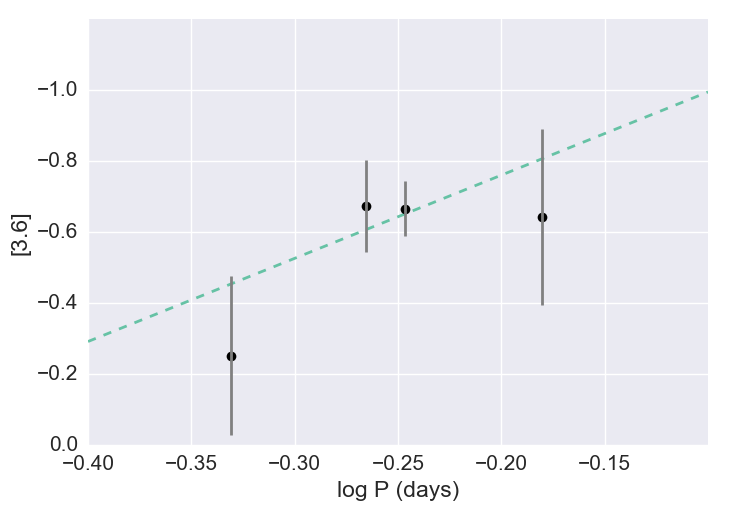

In [13]:
## plot the plz relation

p1 = np.arange(-0.4,-0.1,0.05)
feh1 = np.mean(rrab_cal_df.Fe_H)
axp1 = mp.subplot(111)

axp1.plot(p1, -2.342*p1 + zp_36 + feh1*feh_36, ls='--', label="[3.6]")
axp1.errorbar(rrab_cal_df.logP, rrab_cal_df.M_abs_3p6, yerr=rrab_cal_df.M_err_3p6, ls='None',zorder=4, color='Grey',)
axp1.plot(rrab_cal_df.logP, rrab_cal_df.M_abs_3p6, 'ko', ls='None')
axp1.invert_yaxis()
mp.xlabel('log P (days)')
mp.ylabel('[3.6]')
myaxis=[-0.4, -0.1, 0.0, -1.2]
axp1.axis(myaxis)

print('zp = ({0:.3f} $\pm$ {1:.3f}) fe_h = ({2:.3f} $\pm$ {3:.3f})'.format(zp_36, e_zp_36, feh_36, e_feh_36))

### For comparison: Neeley et al. (2015) Figure 10(a)
* PL relation using 5 RRL (RRab + RRc (fundamentalised))

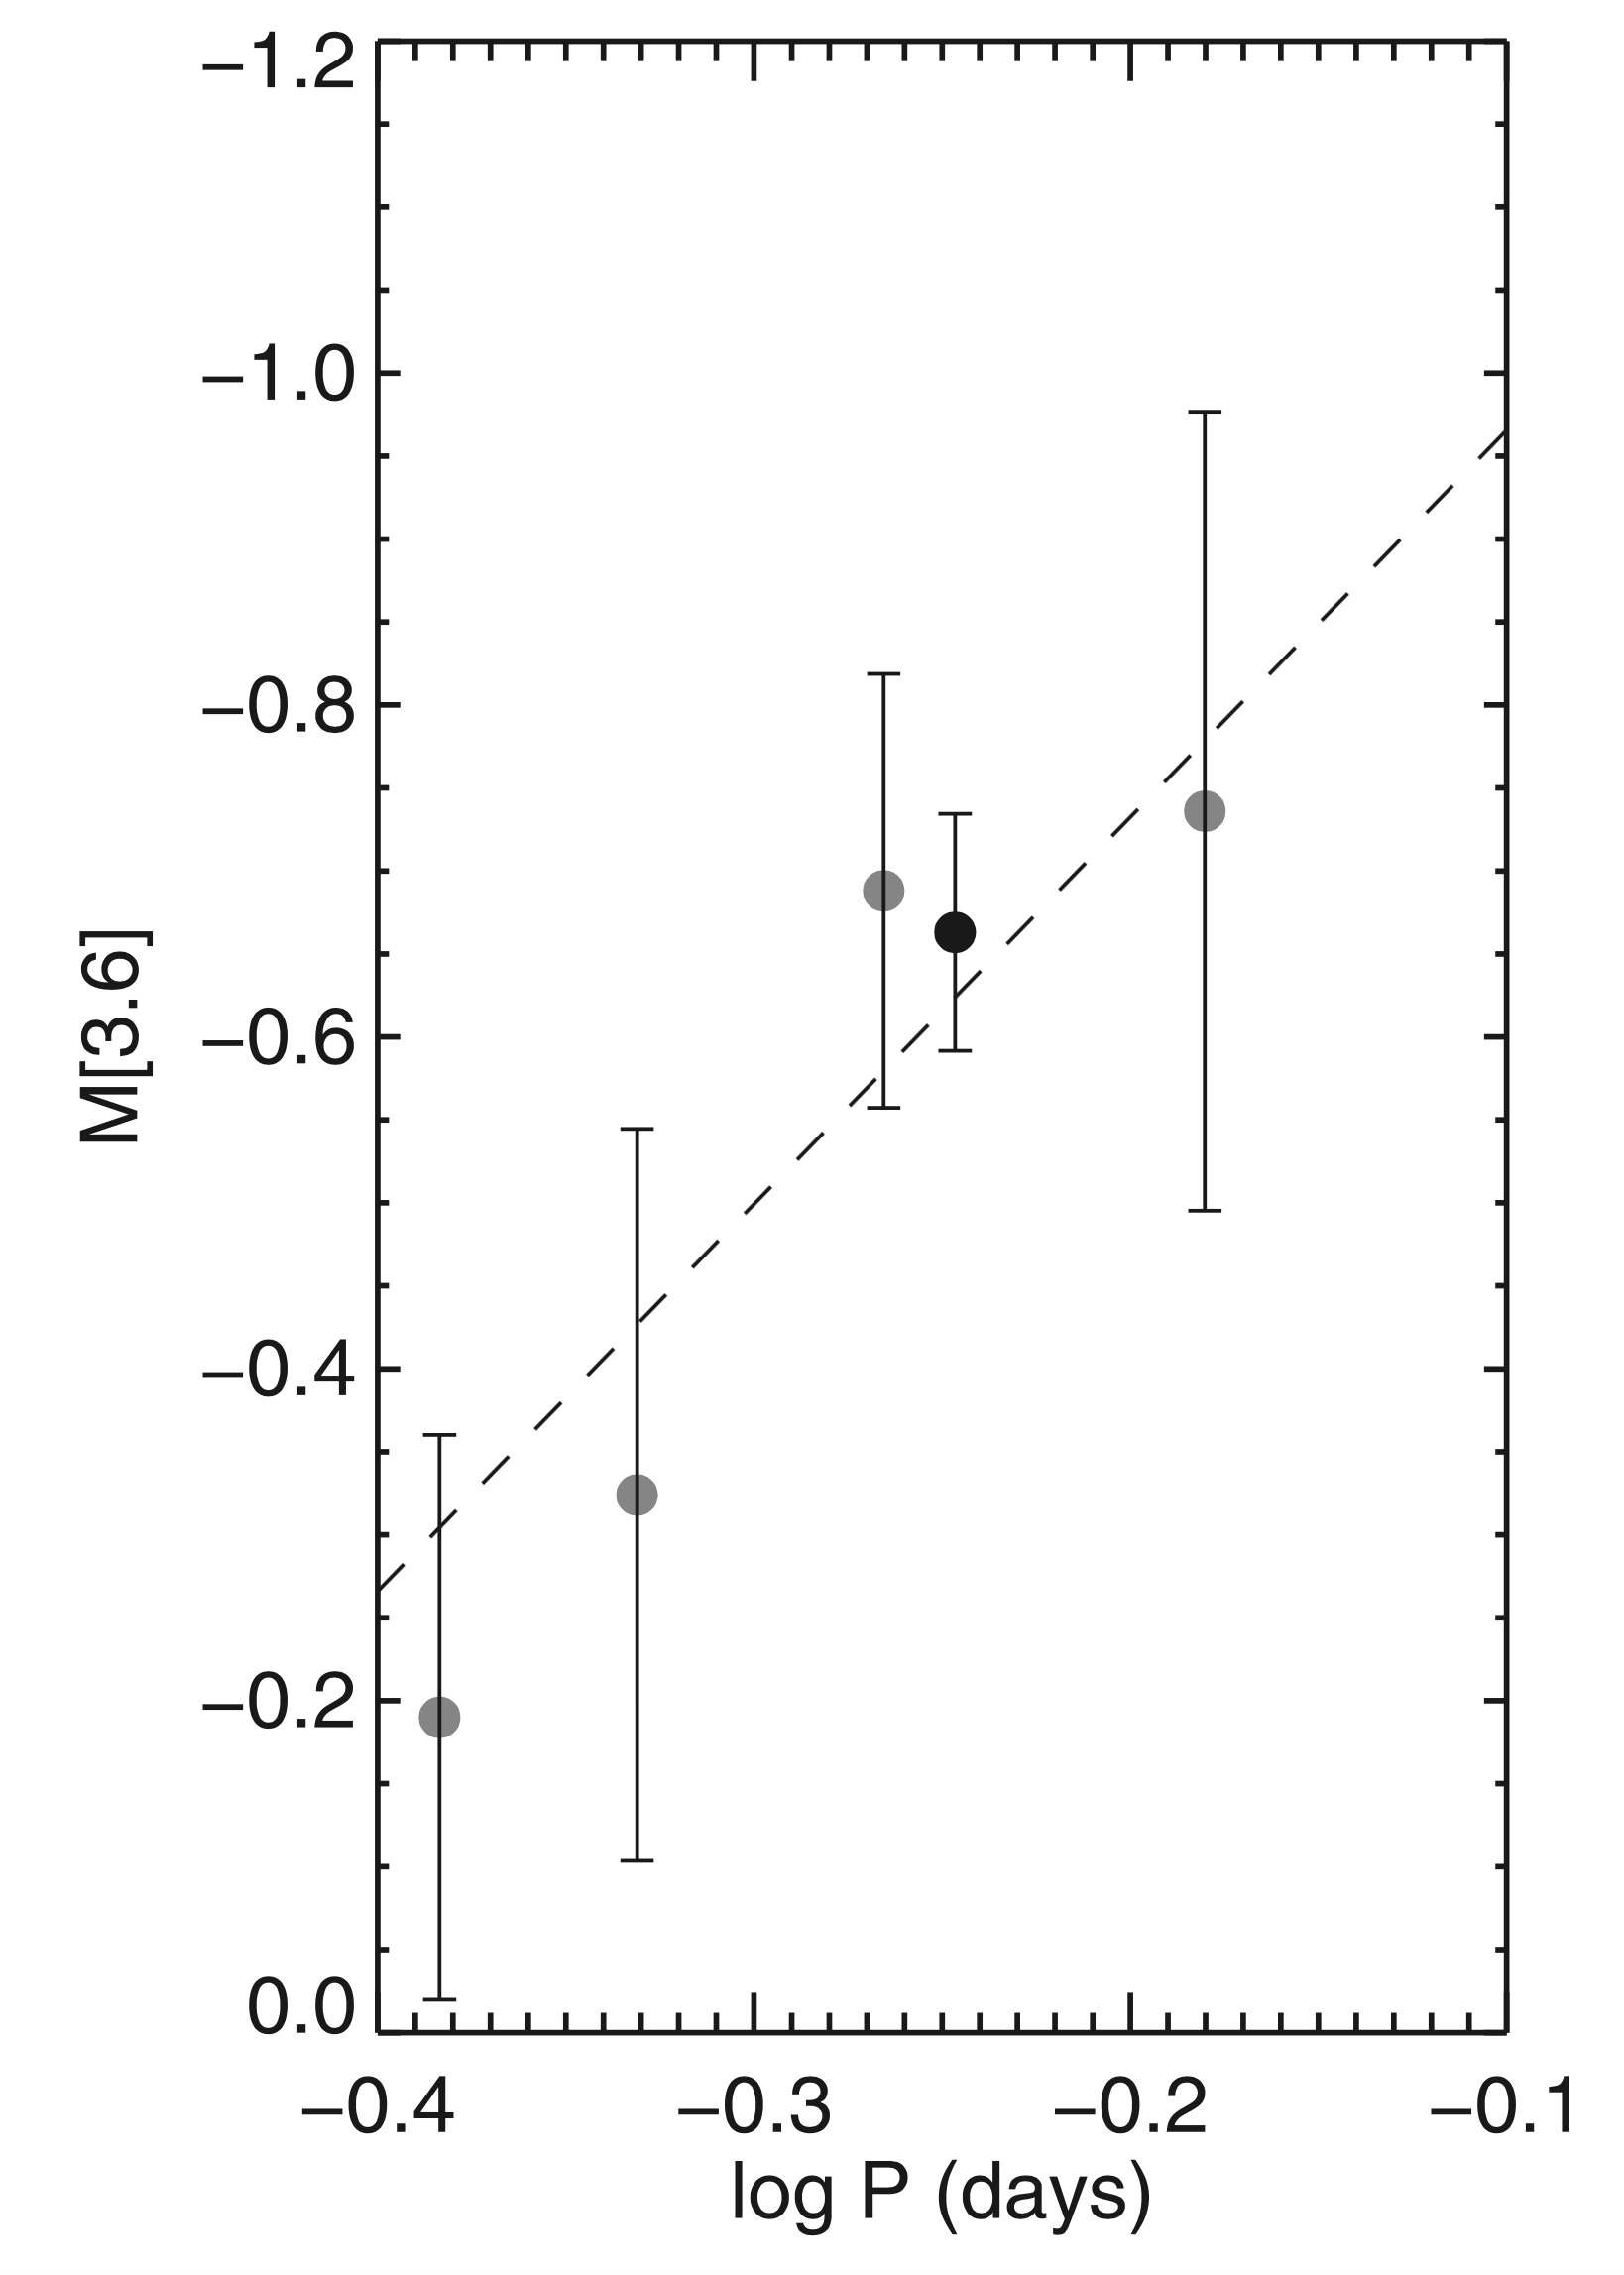

In [14]:
Image('neeley_fig10a.png', width=400)

## Abs mag differences between Neeley and this analysis?
* Any differences in absolute magnitude in Neeley analysis and this one should be due to these factors:

 1) Slight change in Spitzer calibration when Neeley analysis was initially performed
 
 2) This analysis doesn't use the Lutz-Kelker correction
 
 3) Different extinction values (but how different are they?

In [15]:
### name order = xycyg, sudra, rrlyr, uvoct, 
rrab_cal_df['neeley_abs'] = [-0.324, -0.736, -0.663, -0.688]
rrab_cal_df['neeley_abs_sigma'] = [0.221, 0.0241, 0.071, 0.131]
rrab_cal_df['neeley_lkh'] = [-0.09, -0.11, -0.02, -0.03]
rrab_cal_df['neeley_A_36'] = [0.020, 0.002, 0.009, 0.018]

In [16]:
rrab_cal_df['delta_mag'] = rrab_cal_df.apply(lambda x: (x.M_abs_3p6 - x.neeley_abs), axis=1)

In [17]:
rrab_cal_df

,Name_lower,mag_3p6,err_3p6,mag_4p5,err_4p5,P_final,HJD_max,RRL_type,Fe_H,Name,...,logP,mu,e_mu,M_err_3p6,M_err_4p5,neeley_abs,neeley_abs_sigma,neeley_lkh,neeley_A_36,delta_mag
0,xzcyg,8.657,0.009,8.639,0.008,0.466599,2456750.50,RRab,-1.44,XZ Cyg,...,-0.331056,8.886418,0.221816,0.222898,0.222860,-0.324,0.2210,-0.09,0.020,0.071582
1,sudra,8.598,0.008,8.580,0.009,0.660420,2456750.50,RRab,-1.80,SU Dra,...,-0.180180,9.238558,0.245716,0.246659,0.246693,-0.736,0.0241,-0.11,0.002,0.093442
2,rrlyr,6.470,0.009,6.461,0.009,0.566838,2456750.25,RRab,-1.39,RR Lyr,...,-0.246541,7.118293,0.074908,0.078053,0.078053,-0.663,0.0710,-0.02,0.009,-0.003293
3,uvoct,8.180,0.009,8.167,0.009,0.542580,2456750.50,RRab,-1.74,UV Oct,...,-0.265536,8.835019,0.127132,0.129010,0.129010,-0.688,0.1310,-0.03,0.018,0.014981


In [18]:
def delta_mag_fit(x, m, c):
    return m*x + c

-1.03150497271 -0.0202912156318


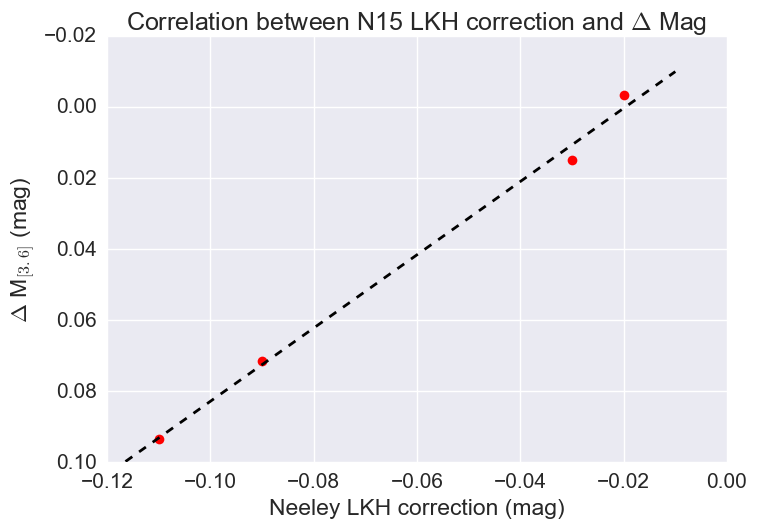

In [19]:
p1 = np.arange(-0.15, 0.0, 0.01)
result = curve_fit(delta_mag_fit, rrab_cal_df.neeley_lkh, rrab_cal_df.delta_mag)

slope = result[0][0]
zp = result[0][1]
e_slope = result[1][0,0]
e_zp = result[1][1,1]

axp1 = mp.subplot(111)
axp1.plot(rrab_cal_df.neeley_lkh, rrab_cal_df.delta_mag, 'ro')
axp1.plot(p1, slope*p1 + zp, 'k--')
axp1.invert_yaxis()
mp.axis([-0.12, 0.00, 0.10, -0.02])
mp.xlabel('Neeley LKH correction (mag)')
mp.ylabel('$\Delta$ M$_{[3.6]}$ (mag)')
mp.title('Correlation between N15 LKH correction and $\Delta$ Mag')

print (slope, zp)

In [20]:
rrab_cal_df['delta_red'] = rrab_cal_df.apply(lambda x: (x.A_3p6 - x.neeley_A_36), axis=1)

-6.38937617513 0.0633459736861


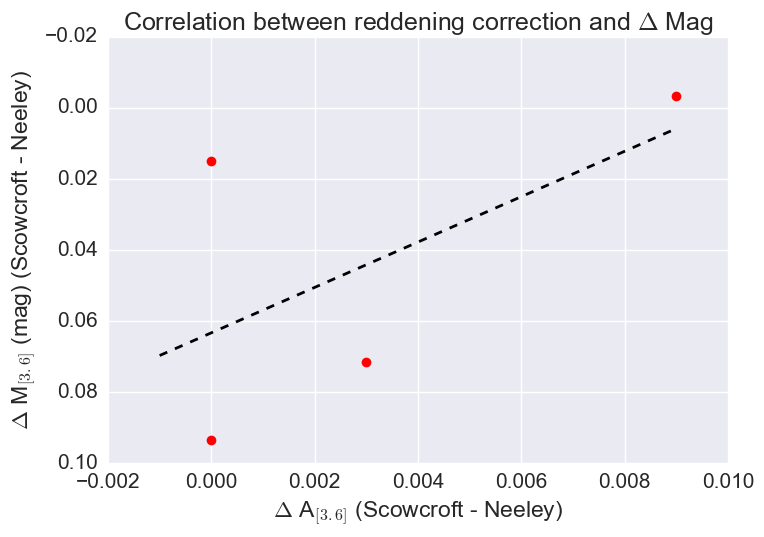

In [21]:
p1 = np.arange(-0.001, 0.01, 0.001)
result = curve_fit(delta_mag_fit, rrab_cal_df.delta_red, rrab_cal_df.delta_mag)

slope = result[0][0]
zp = result[0][1]
e_slope = result[1][0,0]
e_zp = result[1][1,1]

axp1 = mp.subplot(111)
axp1.plot(rrab_cal_df.delta_red, rrab_cal_df.delta_mag, 'ro')
axp1.plot(p1, slope*p1 + zp, 'k--')
axp1.invert_yaxis()
mp.xlabel('$\Delta$ A$_{[3.6]}$ (Scowcroft - Neeley)')
mp.ylabel('$\Delta$ M$_{[3.6]}$ (mag) (Scowcroft - Neeley)')
mp.title('Correlation between reddening correction and $\Delta$ Mag')
x1,x2,y1,y2 = mp.axis()
mp.axis([x1, x2, 0.10, -0.02])



print (slope, zp)

Uncertainties on the absolute magnitudes are very consistent between the two analyses. I think the small differences are because of the treatment of uncertainties in extinction.

In [22]:
rrab_cal_df['M_err_3p6'], rrab_cal_df['neeley_abs_sigma']

(0    0.222898
 1    0.246659
 2    0.078053
 3    0.129010
 Name: M_err_3p6, dtype: float64, 0    0.2210
 1    0.0241
 2    0.0710
 3    0.1310
 Name: neeley_abs_sigma, dtype: float64)

-7.30881285038 -0.0892079893587


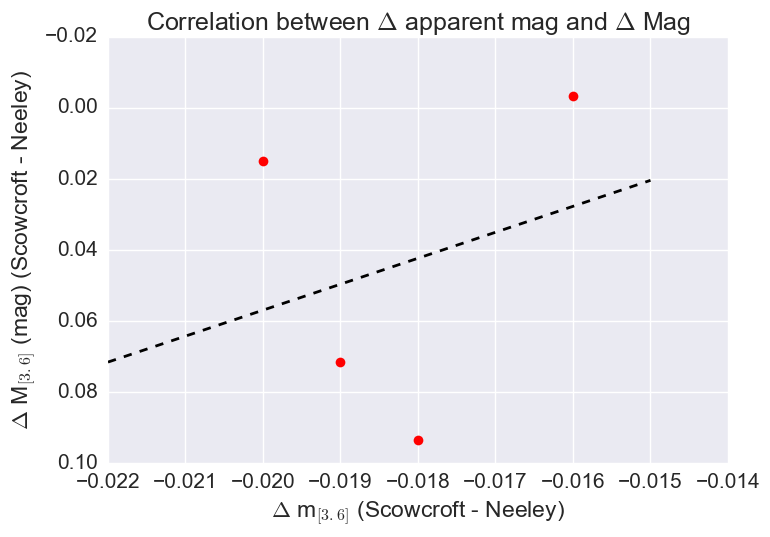

In [23]:
rrab_cal_df['neeley_app_mag'] = [8.676, 8.616, 6.486, 8.200]
rrab_cal_df['delta_app_mag'] = rrab_cal_df.apply(lambda x: (x.mag_3p6 - x.neeley_app_mag), axis=1)

p1 = np.arange(-0.022, -0.014, 0.001)
result = curve_fit(delta_mag_fit, rrab_cal_df.delta_app_mag, rrab_cal_df.delta_mag)

slope = result[0][0]
zp = result[0][1]
e_slope = result[1][0,0]
e_zp = result[1][1,1]

axp1 = mp.subplot(111)
axp1.plot(rrab_cal_df.delta_app_mag, rrab_cal_df.delta_mag, 'ro')
axp1.plot(p1, slope*p1 + zp, 'k--')
axp1.invert_yaxis()
mp.xlabel('$\Delta$ m$_{[3.6]}$ (Scowcroft - Neeley)')
mp.ylabel('$\Delta$ M$_{[3.6]}$ (mag) (Scowcroft - Neeley)')
mp.title('Correlation between $\Delta$ apparent mag and $\Delta$ Mag')
x1,x2,y1,y2 = mp.axis()
mp.axis([x1, x2, 0.10, -0.02])



print (slope, zp)

* Maximum difference in apparent magnitude is -0.02 mag
* Range is -0.02 to -0.016 mag
* These changes are not due to the changes in photometry

## Changes in the PLZ are due to this analysis not using the LKH correction, which we have made the decision not to apply.

# RRab [3.6] PLZ Relation from Galactic Calibrators:

$M_{[3.6]} = -2.342 \log P$ {{"%+.3f" % feh_36}} ($\pm$ {{"%.3f" % e_feh_36}})  $\text{[Fe/H]}$  {{"%+.3f" % zp_36}} ($\pm$ {{"%.3f" % e_zp_36}})





## Repeat above analysis for [4.5]

zp = (-1.193 $\pm$ 0.325) fe_h = (0.031 $\pm$ 0.143)


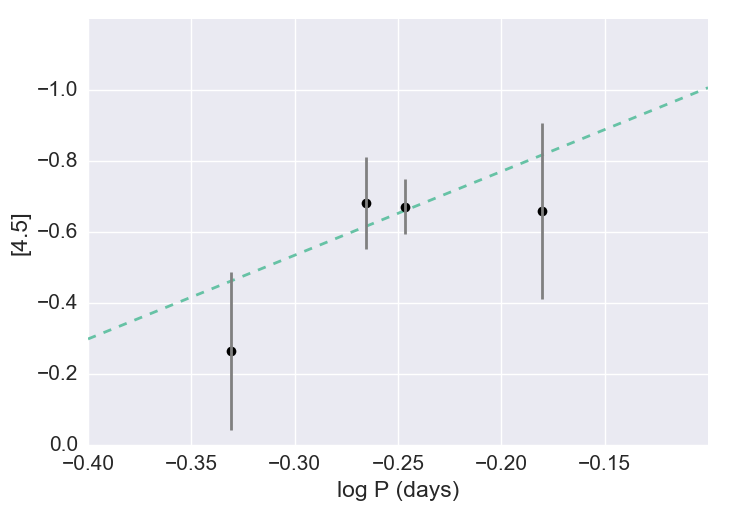

In [24]:
result = curve_fit(M4_ab_45, (rrab_cal_df.logP, rrab_cal_df.Fe_H), rrab_cal_df.M_abs_4p5, sigma=rrab_cal_df.M_err_4p5, absolute_sigma=True) ### make this work

zp_45 = result[0][0]
feh_45 = result[0][1]

e_zp_45 = result[1][0,0]
e_feh_45 = result[1][1,1]

p1 = np.arange(-0.4,-0.1,0.05)
feh1 = np.mean(rrab_cal_df.Fe_H)
axp1 = mp.subplot(111)

axp1.plot(p1, -2.358*p1 + zp_45 + feh1*feh_45, ls='--', label="[4.5]")
axp1.errorbar(rrab_cal_df.logP, rrab_cal_df.M_abs_4p5, yerr=rrab_cal_df.M_err_4p5, ls='None',zorder=4, color='Grey',)
axp1.plot(rrab_cal_df.logP, rrab_cal_df.M_abs_4p5, 'ko', ls='None')
axp1.invert_yaxis()
mp.xlabel('log P (days)')
mp.ylabel('[4.5]')
myaxis=[-0.4, -0.1, 0.0, -1.2]
axp1.axis(myaxis)

print('zp = ({0:.3f} $\pm$ {1:.3f}) fe_h = ({2:.3f} $\pm$ {3:.3f})'.format(zp_45, e_zp_45, feh_45, e_feh_45))

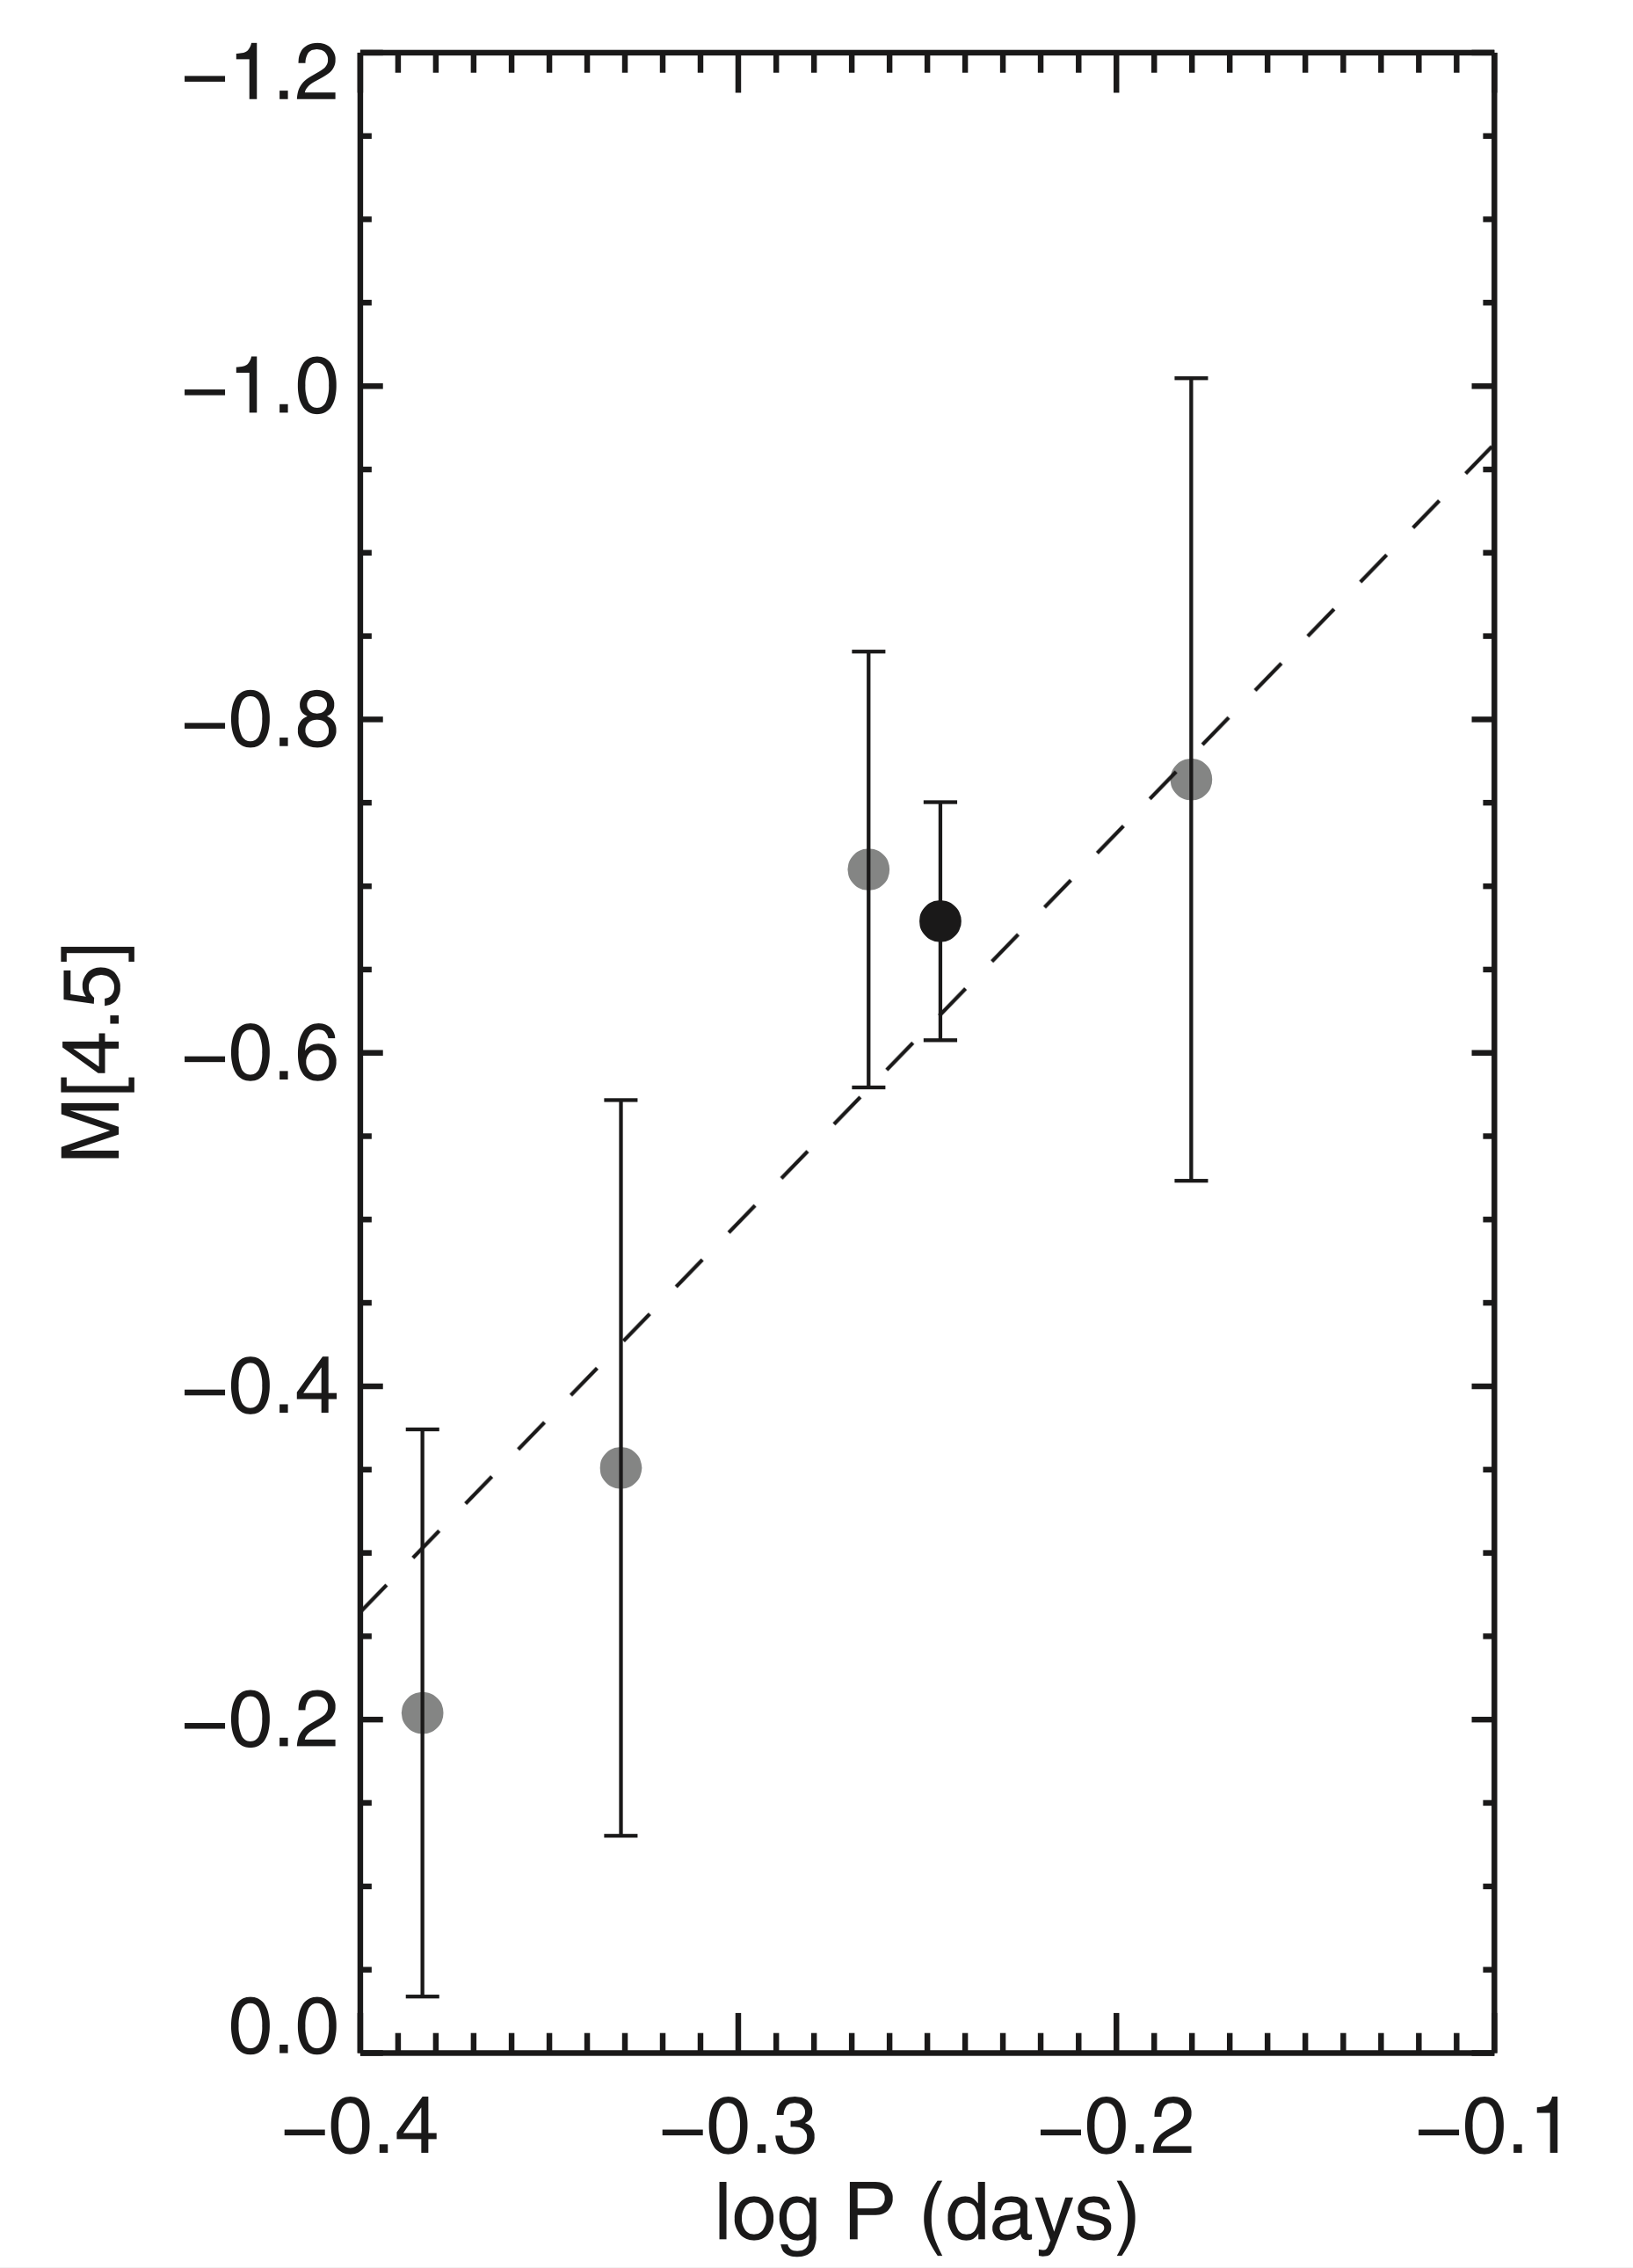

In [25]:
Image('neeley_fig10b.png', width=400)

In [26]:
rrab_cal_df['neeley_abs_45'] = [-0.361, -0.764, -0.679, -0.710]
rrab_cal_df['neeley_abs_sigma_45'] = [0.221, 0.0241, 0.071, 0.131]
rrab_cal_df['neeley_lkh'] = [-0.09, -0.11, -0.02, -0.03]
rrab_cal_df['neeley_A_45'] = [0.016, 0.002, 0.007, 0.014]

In [27]:
rrab_cal_df['delta_mag_45'] = rrab_cal_df.apply(lambda x: (x.M_abs_4p5 - x.neeley_abs_45), axis=1)

-1.08937731363 -0.00990823694087


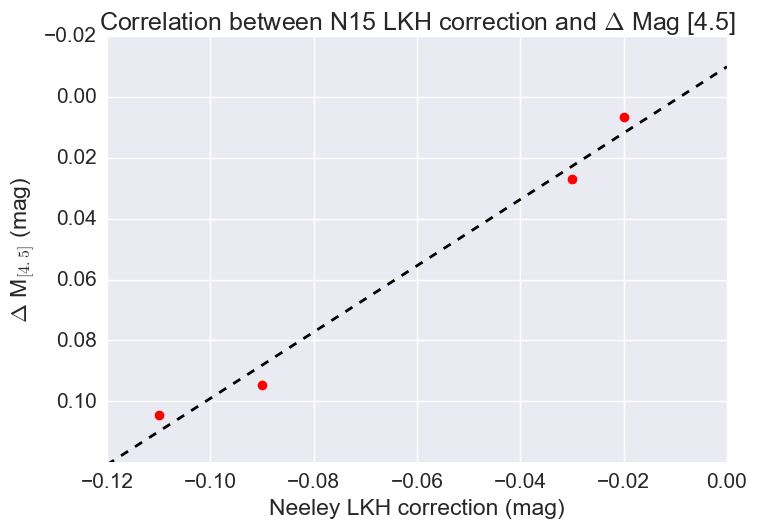

In [28]:
p1 = np.arange(-0.12, 0.01, 0.01)
result = curve_fit(delta_mag_fit, rrab_cal_df.neeley_lkh, rrab_cal_df.delta_mag_45)

slope = result[0][0]
zp = result[0][1]
e_slope = result[1][0,0]
e_zp = result[1][1,1]

axp1 = mp.subplot(111)
axp1.plot(rrab_cal_df.neeley_lkh, rrab_cal_df.delta_mag_45, 'ro')
axp1.plot(p1, slope*p1 + zp, 'k--')
axp1.invert_yaxis()
mp.axis([-0.12, 0.00, 0.12, -0.02])
mp.xlabel('Neeley LKH correction (mag)')
mp.ylabel('$\Delta$ M$_{[4.5]}$ (mag)')
mp.title('Correlation between N15 LKH correction and $\Delta$ Mag [4.5]')

print (slope, zp)

In [29]:
rrab_cal_df['delta_red_45'] = rrab_cal_df.apply(lambda x: (x.A_4p5 - x.neeley_A_45), axis=1)

-8.49198644103 0.0815308078736


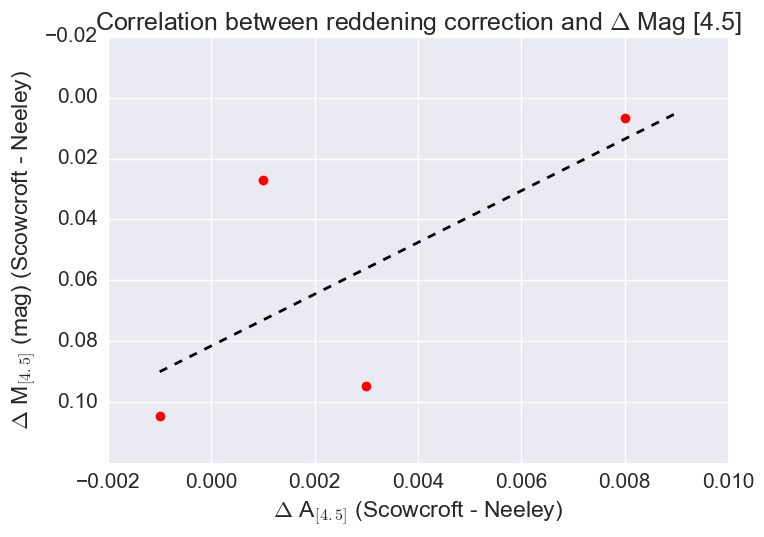

In [30]:
p1 = np.arange(-0.001, 0.01, 0.001)
result = curve_fit(delta_mag_fit, rrab_cal_df.delta_red_45, rrab_cal_df.delta_mag_45)

slope = result[0][0]
zp = result[0][1]
e_slope = result[1][0,0]
e_zp = result[1][1,1]

axp1 = mp.subplot(111)
axp1.plot(rrab_cal_df.delta_red_45, rrab_cal_df.delta_mag_45, 'ro')
axp1.plot(p1, slope*p1 + zp, 'k--')
axp1.invert_yaxis()
mp.xlabel('$\Delta$ A$_{[4.5]}$ (Scowcroft - Neeley)')
mp.ylabel('$\Delta$ M$_{[4.5]}$ (mag) (Scowcroft - Neeley)')
mp.title('Correlation between reddening correction and $\Delta$ Mag [4.5]')
x1,x2,y1,y2 = mp.axis()
mp.axis([x1, x2, 0.12, -0.02])



print (slope, zp)

-4.92968699315 0.0236700362087


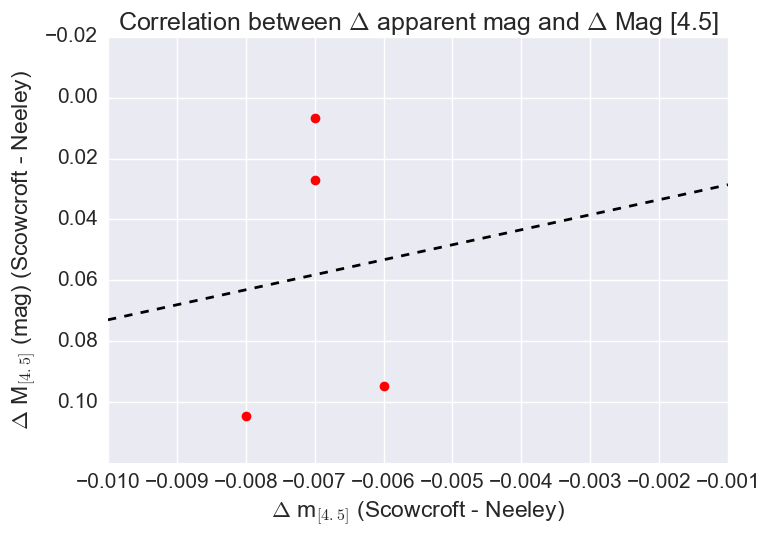

In [31]:
rrab_cal_df['neeley_app_mag_45'] = [8.645, 8.588, 6.468, 8.174]
rrab_cal_df['delta_app_mag_45'] = rrab_cal_df.apply(lambda x: (x.mag_4p5 - x.neeley_app_mag_45), axis=1)

p1 = np.arange(-0.01, -0.0, 0.001)
result = curve_fit(delta_mag_fit, rrab_cal_df.delta_app_mag_45, rrab_cal_df.delta_mag_45)

slope = result[0][0]
zp = result[0][1]
e_slope = result[1][0,0]
e_zp = result[1][1,1]

axp1 = mp.subplot(111)
axp1.plot(rrab_cal_df.delta_app_mag_45, rrab_cal_df.delta_mag_45, 'ro')
axp1.plot(p1, slope*p1 + zp, 'k--')
axp1.invert_yaxis()
mp.xlabel('$\Delta$ m$_{[4.5]}$ (Scowcroft - Neeley)')
mp.ylabel('$\Delta$ M$_{[4.5]}$ (mag) (Scowcroft - Neeley)')
mp.title('Correlation between $\Delta$ apparent mag and $\Delta$ Mag [4.5]')
x1,x2,y1,y2 = mp.axis()
mp.axis([x1, x2, 0.12, -0.02])



print (slope, zp)

Same in [4.5] as in [3.6] - the difference in absolute mags is down the the choice of whether to use the LKH correction. Very slight difference is due to the Spitzer calibration and the uncertainties on the extinction corrections.

Using the IRSA extinctions is more consistent because they can be applied over the whole sky.

# RRab [4.5] PLZ Relation from Galactic Calibrators:

$M_{[4.5]} = -2.358 \log P$ {{"%+.3f" % feh_45}} ($\pm$ {{"%.3f" % e_feh_45}})  $\text{[Fe/H]}$  {{"%+.3f" % zp_45}} ($\pm$ {{"%.3f" % e_zp_45}})




# Application of the PLZ relation to the full CRRP RRab set

## Step 2 - Testing the PLZ relations
* Apply the PLZ relations to the CRRP data set
* Have [3.6] and [4.5] data for all the CRRP Galactic RRL
* Also have metallcities from Monson et al.

Question: If I use the PLZ relation to derive a distance to each of these stars, how well do those distances agree with the Gaia DR1 distances?

In [32]:
rrab_df

,Name_lower,mag_3p6,err_3p6,mag_4p5,err_4p5,P_final,HJD_max,RRL_type,Fe_H,Name,A_3p6,A_4p5,M_abs_3p6,M_abs_4p5,calibrator,logP
0,swand,8.485,0.009,8.472,0.008,0.442260,2456877.00,RRab,-0.24,SW And,0.008,0.007,8.477,8.465,0.0,-0.354322
1,xxand,9.409,0.009,9.384,0.008,0.722757,2456751.00,RRab,-1.94,XX And,0.008,0.007,9.401,9.377,0.0,-0.141008
2,wyant,9.567,0.009,9.548,0.008,0.574346,2456750.50,RRab,-1.48,WY Ant,0.012,0.010,9.555,9.538,0.0,-0.240827
3,xari,7.885,0.009,7.859,0.009,0.651173,2456750.50,RRab,-2.43,X Ari,0.037,0.031,7.848,7.828,0.0,-0.186304
4,stboo,9.834,0.009,9.816,0.009,0.622286,2456750.50,RRab,-1.76,ST Boo,0.004,0.003,9.830,9.813,0.0,-0.206010
5,uyboo,9.721,0.008,9.696,0.009,0.650830,2456750.50,RRab,-2.56,UY Boo,0.007,0.006,9.714,9.690,0.0,-0.186532
6,rrcet,8.501,0.009,8.489,0.008,0.553029,2456750.25,RRab,-1.45,RR Cet,0.004,0.003,8.497,8.486,0.0,-0.257252
7,wcrt,10.506,0.011,10.500,0.011,0.412015,2456750.25,RRab,-0.54,W Crt,0.009,0.007,10.497,10.493,0.0,-0.385087
8,uycyg,9.709,0.009,9.688,0.008,0.560705,2456750.50,RRab,-0.80,UY Cyg,0.047,0.039,9.662,9.649,0.0,-0.251266
9,xzcyg,8.657,0.009,8.639,0.008,0.466599,2456750.50,RRab,-1.44,XZ Cyg,0.023,0.019,8.634,8.620,1.0,-0.331056


In [33]:
def PL_36(period, feh):
    return -2.342 * np.log10(period) + 0.017*feh -1.202

def PL_45(period, feh):
    return -2.358 * np.log10(period) + 0.031*feh - 1.193

In [34]:
rrab_df['M36_derived'] = rrab_df.apply(lambda x: PL_36(x.P_final, x.Fe_H) - x.A_3p6, axis=1)
rrab_df['M45_derived'] = rrab_df.apply(lambda x: PL_45(x.P_final, x.Fe_H) - x.A_4p5, axis=1)



In [35]:
rrab_df['mu_36_derived'] = rrab_df.apply(lambda x: x.mag_3p6 - x.M36_derived, axis=1)
rrab_df['mu_45_derived'] = rrab_df.apply(lambda x: x.mag_4p5 - x.M45_derived, axis=1)

In [36]:
rrab_df

,Name_lower,mag_3p6,err_3p6,mag_4p5,err_4p5,P_final,HJD_max,RRL_type,Fe_H,Name,A_3p6,A_4p5,M_abs_3p6,M_abs_4p5,calibrator,logP,M36_derived,M45_derived,mu_36_derived,mu_45_derived
0,swand,8.485,0.009,8.472,0.008,0.442260,2456877.00,RRab,-0.24,SW And,0.008,0.007,8.477,8.465,0.0,-0.354322,-0.384258,-0.371948,8.869258,8.843948
1,xxand,9.409,0.009,9.384,0.008,0.722757,2456751.00,RRab,-1.94,XX And,0.008,0.007,9.401,9.377,0.0,-0.141008,-0.912740,-0.927644,10.321740,10.311644
2,wyant,9.567,0.009,9.548,0.008,0.574346,2456750.50,RRab,-1.48,WY Ant,0.012,0.010,9.555,9.538,0.0,-0.240827,-0.675144,-0.681011,10.242144,10.229011
3,xari,7.885,0.009,7.859,0.009,0.651173,2456750.50,RRab,-2.43,X Ari,0.037,0.031,7.848,7.828,0.0,-0.186304,-0.843987,-0.860026,8.728987,8.719026
4,stboo,9.834,0.009,9.816,0.009,0.622286,2456750.50,RRab,-1.76,ST Boo,0.004,0.003,9.830,9.813,0.0,-0.206010,-0.753445,-0.764788,10.587445,10.580788
5,uyboo,9.721,0.008,9.696,0.009,0.650830,2456750.50,RRab,-2.56,UY Boo,0.007,0.006,9.714,9.690,0.0,-0.186532,-0.815661,-0.838517,10.536661,10.534517
6,rrcet,8.501,0.009,8.489,0.008,0.553029,2456750.25,RRab,-1.45,RR Cet,0.004,0.003,8.497,8.486,0.0,-0.257252,-0.628166,-0.634350,9.129166,9.123350
7,wcrt,10.506,0.011,10.500,0.011,0.412015,2456750.25,RRab,-0.54,W Crt,0.009,0.007,10.497,10.493,0.0,-0.385087,-0.318305,-0.308704,10.824305,10.808704
8,uycyg,9.709,0.009,9.688,0.008,0.560705,2456750.50,RRab,-0.80,UY Cyg,0.047,0.039,9.662,9.649,0.0,-0.251266,-0.674136,-0.664315,10.383136,10.352315
9,xzcyg,8.657,0.009,8.639,0.008,0.466599,2456750.50,RRab,-1.44,XZ Cyg,0.023,0.019,8.634,8.620,1.0,-0.331056,-0.474147,-0.476010,9.131147,9.115010


In [37]:
### Gaia data:
gaia_df = pd.read_csv('rr_calibrators.csv', header=0, sep=',')

gaia_df file is a merged data file that I created at the gaia sprints. Original data is all in the gaia_sprints folder on github. All raw data straight from the DR1 release and the same data in these spitzer files (i.e. data that went into Monson 2017).

In [41]:
### grabbing the relavent columns from gaia_df

gaia_columns = ['Name', 'id_compare', 'Plx', 'e_Plx']
gaia_sel_df = gaia_df[gaia_columns]
gaia_sel_df.rename(columns={'id_compare':'Name_lower'}, inplace=True)

/Users/vs522/anaconda3/envs/astroconda/lib/python3.5/site-packages/pandas/core/frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [42]:
rrab_gaia_df = rrab_df.merge(gaia_sel_df, on='Name_lower')

In [44]:
rrab_gaia_df

,Name_lower,mag_3p6,err_3p6,mag_4p5,err_4p5,P_final,HJD_max,RRL_type,Fe_H,Name_x,...,M_abs_4p5,calibrator,logP,M36_derived,M45_derived,mu_36_derived,mu_45_derived,Name_y,Plx,e_Plx
0,swand,8.485,0.009,8.472,0.008,0.442260,2456877.00,RRab,-0.24,SW And,...,8.465,0.0,-0.354322,-0.384258,-0.371948,8.869258,8.843948,SWAnd,1.77,0.26
1,wyant,9.567,0.009,9.548,0.008,0.574346,2456750.50,RRab,-1.48,WY Ant,...,9.538,0.0,-0.240827,-0.675144,-0.681011,10.242144,10.229011,WYAnt,0.83,0.23
2,xari,7.885,0.009,7.859,0.009,0.651173,2456750.50,RRab,-2.43,X Ari,...,7.828,0.0,-0.186304,-0.843987,-0.860026,8.728987,8.719026,XAri,2.02,0.22
3,stboo,9.834,0.009,9.816,0.009,0.622286,2456750.50,RRab,-1.76,ST Boo,...,9.813,0.0,-0.206010,-0.753445,-0.764788,10.587445,10.580788,STBoo,0.69,0.33
4,uyboo,9.721,0.008,9.696,0.009,0.650830,2456750.50,RRab,-2.56,UY Boo,...,9.690,0.0,-0.186532,-0.815661,-0.838517,10.536661,10.534517,UYBoo,0.21,0.26
5,xzcyg,8.657,0.009,8.639,0.008,0.466599,2456750.50,RRab,-1.44,XZ Cyg,...,8.620,1.0,-0.331056,-0.474147,-0.476010,9.131147,9.115010,XZCyg,1.56,0.23
6,dxdel,8.650,0.009,8.637,0.008,0.472617,2456750.25,RRab,-0.39,DX Del,...,8.617,0.0,-0.325491,-0.470330,-0.457582,9.120330,9.094582,DXDel,1.66,0.22
7,sudra,8.598,0.008,8.580,0.009,0.660420,2456750.50,RRab,-1.80,SU Dra,...,8.579,1.0,-0.180180,-0.812619,-0.824936,9.410619,9.404936,SUDra,1.43,0.28
8,swdra,9.303,0.009,9.285,0.009,0.569670,2456750.50,RRab,-1.12,SW Dra,...,9.283,0.0,-0.244377,-0.651710,-0.653480,9.954710,9.938480,SWDra,1.01,0.23
9,rxeri,8.336,0.009,8.312,0.008,0.587246,2456750.50,RRab,-1.33,RX Eri,...,8.302,0.0,-0.231180,-0.695187,-0.699108,9.031187,9.011108,RXEri,1.83,0.24


# rrab_gaia_df has 27 RRab with Gaia DR1 parallaxes, Spitzer photometry and Monson [Fe/H] metallicities where we can test this calibration

## Full sample has 37 stars

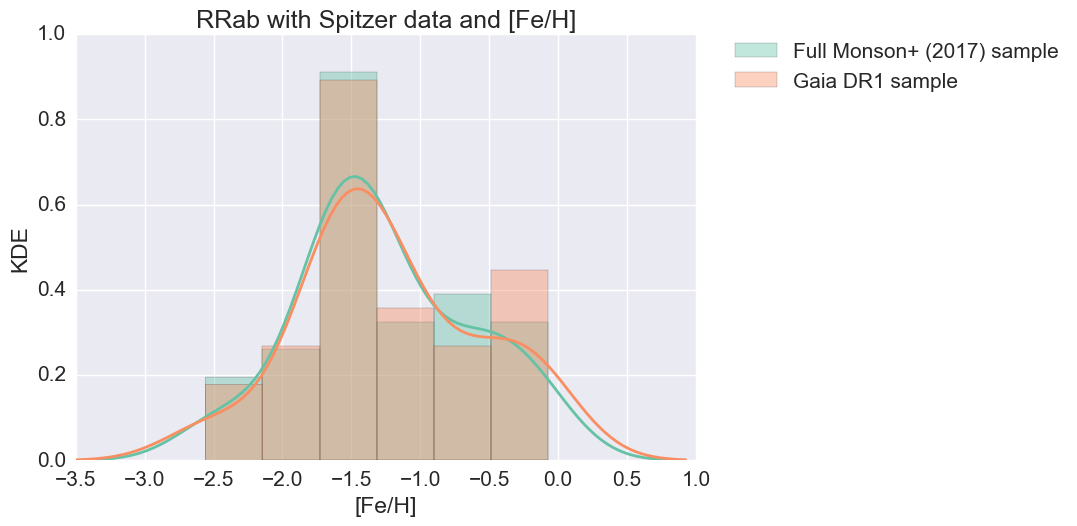

In [73]:
### histogram of the metallicities of these stars, out of interest:

axp1 = sns.distplot(rrab_df.Fe_H, bins=6, label='Full Monson+ (2017) sample')


axp1 = sns.distplot(rrab_gaia_df.Fe_H, bins=6, label='Gaia DR1 sample')
mp.xlabel('[Fe/H]')
mp.title('RRab with Spitzer data and [Fe/H]')
mp.axis([-3.5, 1.0, 0, 1.0])
mp.ylabel('KDE')
mp.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
